In [1]:
import os
import glob

# Rapid disk storage, for queueing installations
HOME = "/home/ubuntu"

# Permanent disk storage
WORK = os.path.join(HOME, "riceuniversity")

In [2]:
SUBJECT_NAME = "John"
SUBJECT_DIRECTORY = os.path.join(WORK, "john")

# Single-subject inference
ALLOWED_IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg', '*.png']
SUBJECT_RAW_IMAGES = [filepath for ext in ALLOWED_IMAGE_EXTENSIONS for filepath in glob.glob(os.path.join(SUBJECT_DIRECTORY, ext))]

In [5]:
# Check that CUDA Version is 12.8 and GCC version is 13.2.*
!nvidia-smi
!gcc --version

import torch
assert torch.version.cuda=='12.8', "CUDA Version not 12.8. Check notebook, conda, and ipykernel installation."

Thu May  1 17:44:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   33C    P0             73W /  700W |       2MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Captioning with Gemma

In [6]:
import torch
from transformers import AutoProcessor, Gemma3ForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import os
import sys

MODEL_ID = "google/gemma-3-4b-it"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float32

try:
    processor = AutoProcessor.from_pretrained(
        MODEL_ID,
        padding_side="left",
        do_pan_and_scan=True
    )
    model = Gemma3ForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=DTYPE,
        device_map="auto"
    ).eval()
except Exception as e:
    print(f"Loading error: {e}")

def generate_local_image_caption(image_path, prompt):
    try:
        raw_image = Image.open(image_path).convert("RGB")
        full_prompt = "<start_of_image> " + prompt
        inputs = processor(
            text=full_prompt,
            images=raw_image,
            return_tensors="pt"
        ).to(model.device, dtype=DTYPE)
        with torch.inference_mode():
            output = model.generate(
                **inputs,
                max_new_tokens=100,
                do_sample=False
            )
        caption_raw = processor.decode(output[0], skip_special_tokens=True)
        lines = [ln.strip() for ln in caption_raw.splitlines() if ln.strip()]
        if not lines:
            return "" 
        return lines[-1]
    except Exception as e:
        return f"Generation error: {e}"

/home/ubuntu/miniforge3/envs/gcc13env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


In [ ]:
import json
import os

CAPTION_UTILITY = f"You must call the person in photo {SUBJECT_NAME}. \
Provide a single, detailed, objective caption for this picture covering things such as setting, clothing, etc. \
Do not output anything except the caption."

output_filepath = os.path.join(SUBJECT_DIRECTORY, "metadata.jsonl")

if os.path.exists(output_filepath):
    raise FileExistsError(f"Error: Output file '{output_filepath}' already exists. Aborting script to prevent overwriting.")

with open(output_filepath, 'w') as out:
    for imgpath in SUBJECT_RAW_IMAGES:
        file_name = os.path.basename(imgpath)
        print(f"Processing {file_name} for captioning...")
        entry = {"file_name": file_name, "prompt": generate_local_image_caption(imgpath, CAPTION_UTILITY)}
        json.dump(entry, out)
        out.write('\n')

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

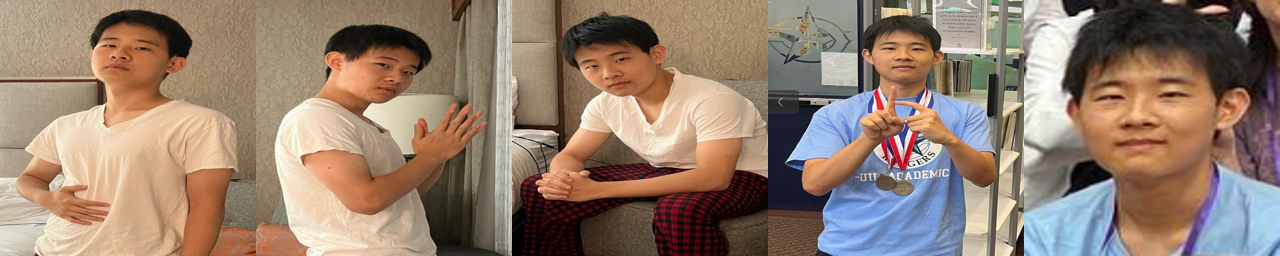

In [6]:
import os, glob

img_paths = os.path.join(WORK, "./john/*.png")
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [8]:
import glob
from PIL import Image

local_dir = os.path.join(WORK, "john")
imgs_and_paths = [(path, Image.open(path)) for path in glob.glob(os.path.join(local_dir, "*.png"))]

assert len(imgs_and_paths) > 0, "imgs_and_paths is empty"

In [10]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /home/ubuntu/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [12]:
import huggingface_hub

with open(os.path.join(WORK, "HF_TOKEN.txt"), "r") as file:
    content = file.read()
    content.strip()

huggingface_hub.login(content)

In [14]:
!pip install datasets -q

In [23]:
!cd /home/ubuntu/riceuniversity && accelerate launch train_dreambooth_lora_flux.py \
  --pretrained_model_name_or_path "black-forest-labs/FLUX.1-dev" \
  --dataset_name john \
  --output_dir "john_flux_lora" \
  --caption_column "prompt" \
  --instance_prompt "a photo of John" \
  --resolution 1024 \
  --train_batch_size 1 \
  --gradient_accumulation_steps 3 \
  --gradient_checkpointing \
  --mixed_precision "fp16" \
  --learning_rate 1e-4 \
  --lr_scheduler "constant" \
  --lr_warmup_steps 0 \
  --max_train_steps 1000 \
  --checkpointing_steps 100 \
  --guidance_scale 3.5 \
  --rank 128 \
  --seed 0

Could not find the bitsandbytes CUDA binary at PosixPath('/home/ubuntu/miniforge3/envs/gcc13env/lib/python3.13/site-packages/bitsandbytes/libbitsandbytes_cuda128.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
/home/ubuntu/miniforge3/envs/gcc13env/lib/python3.13/site-packages/accelerate/accelerator.py:506: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
05/01/2025 14:13:35 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all co

In [51]:
import gc
del pipeline
del image
gc.collect()
torch.cuda.empty_cache()

In [52]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    torch_dtype=torch.bfloat16,
    num_cycles=50
).to("cuda")

pipeline.load_lora_weights(
    "/home/ubuntu/riceuniversity/john_flux_lora",
    weight_name="pytorch_lora_weights.safetensors"
)

Keyword arguments {'num_cycles': 50} are not expected by FluxPipeline and will be ignored.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 73.33it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 16.90it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


100%|██████████| 45/45 [00:11<00:00,  3.98it/s]


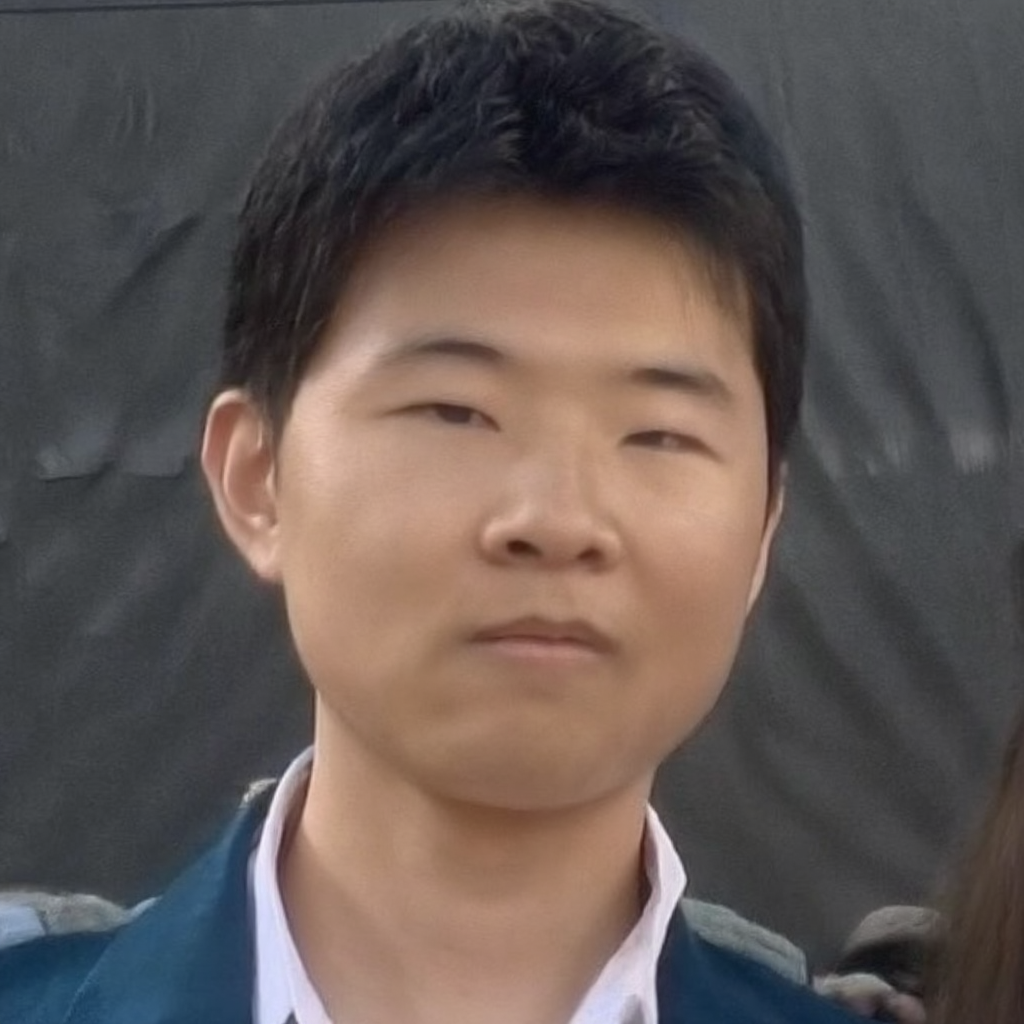

In [54]:
image = pipeline(
    prompt="a photo of John man digital realistic",
    num_inference_steps=45,
).images[0]
image